<a href="https://colab.research.google.com/github/pythonuzgit/elmurodov/blob/master/Knowledge%20Graph/Knowledge_learning_with_machine_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install 'networkx<2.7'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 32.1 MB/s eta 0:00:00
  Attempting uninstall: networkx
    Found existing installation: networkx 3.0
    Uninstalling networkx-3.0:
      Successfully uninstalled networkx-3.0


In [ ]:
!pip install 'scipy>=1.8'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 42.5 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.7.3
    Uninstalling scipy-1.7.3:
      Successfully uninstalled scipy-1.7.3


In [ ]:
import spacy
import numpy as np # linear algebra
import pandas as pd

import spacy
import pandas as pd
import requests 
from spacy import displacy

nlp = spacy.load('en_core_web_sm')

from spacy.tokens import Span
from spacy.matcher import Matcher
 
import matplotlib.pyplot as plot
from tqdm import tqdm
import networkx as ntx
#import neptune.new as neptune

import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline
 
%matplotlib inline

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [ ]:
nlp = spacy.load('en_core_web_sm')

doc = nlp("The 22-year-old recently won ATP Challenger tournament.")

for tok in doc:
    print(tok.text, "...", tok.dep_)

The ... det
22 ... nummod
- ... punct
year ... npadvmod
- ... punct
old ... nsubj
recently ... advmod
won ... ROOT
ATP ... compound
Challenger ... compound
tournament ... dobj
. ... punct


Load data

In [ ]:
kg_df = pd.read_csv('/content/kg_data.csv')

In [ ]:
kg_df.shape

(29994, 4)

In [ ]:
kg_df.head()

,sentence,source,target,relation
0,Harper has two brothers Joel and Peter.,Harper,two brothers,has
1,Two dogs bare their teeth and bark.,Two dogs,teeth,bare
2,A recording of the shot has gained upwards of two million views on YouTube.,recording,two million two YouTube,gained
3,Never mind the patch exclaimed the happy Woodman.,patch,happy Woodman,mind
4,Shelton attended North Carolina State University and was a member of Pershing Rifles.,Shelton,Pershing Rifles,attended


In [ ]:
kg_df.tail()

,sentence,source,target,relation
29989,But otherwise how far above the human listener is the brute.,NaN,human listener,is
29990,A football team plays before a nearlyempty stadium.,football team,nearlyempty stadium,plays before
29991,David Taylor Model Basin was to assist with hydrodynamics and propulsion.,Taylor Model Basin,hydrodynamics,was
29992,Come on Dont be such a slowcoach.,NaN,NaN,be
29993,Theres a lot more you can do with a tighter integration with the eye tracking API.,lot you,tighter eye tracking API,s


In [ ]:
doc = nlp("confused and frustrated, connie decides to leave on her own.")

for tok in doc:
    print(tok.text, "...", tok.dep_)

confused ... advcl
and ... cc
frustrated ... conj
, ... punct
connie ... nsubj
decides ... ROOT
to ... aux
leave ... xcomp
on ... prep
her ... poss
own ... pobj
. ... punct


import data sentences

In [ ]:
sentence = kg_df['sentence'][:5000]

Entity Pairs Extraction

To build a knowledge graph, the most important things are the nodes and the edges between them

In [ ]:
def get_entities(sent):
  #chunk1
  ent1 = ''
  ent2 = ''

  prv_tok_dep = ''
  prv_tok_text = ''

  prefix = ''
  modifier = ''

  for tok in nlp(sent):
    if tok.dep_ != "punct":
      if tok.dep_ == 'compound':
        prefix = tok.text
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " " + tok.text

      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text 

        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " " + tok.text 

       ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier + " " + prefix + " " + tok.text

        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""


      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier + " " + prefix + " " + tok.text  



      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text 


  return [ent1.strip(), ent2.strip()]      
     



In [ ]:
get_entities("the film had 200 patents")

['film', '200  patents']

In [ ]:
entity_pairs = []

for i in tqdm(sentence):
  entity_pairs.append(get_entities(i))

100%|██████████| 5000/5000 [00:42<00:00, 117.89it/s]


In [ ]:
entity_pairs[10:20]

[['still  tongue', 'wise  head'],
 ['thus  Shroud', ''],
 ['We', 'two  months'],
 ['Josh Dallas', 'episode'],
 ['you', 'field'],
 ['novel', 'also  terrorists'],
 ['Keay', 'Palmerston North'],
 ['acquisition', 'competent merger control authorities'],
 ['', 'Lucy Maud Montgomery'],
 ['Occasionally  rings', 'bracelets']]

Relation / Predicate Extraction

In [ ]:
def predicates(sent):

    doc = nlp(sent)

    # Matcher class object 
    matcher = Matcher(nlp.vocab)

    #define the pattern 
    pattern = [{'DEP':'ROOT'},
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

    matcher.add("matching_1", [pattern]) 

    matches = matcher(doc)
    k = len(matches) - 1

    span = doc[matches[k][1]:matches[k][2]] 

    return(span.text)

In [ ]:
 predicates = [predicates(i) for i in tqdm(sentence)]

100%|██████████| 5000/5000 [00:44<00:00, 111.50it/s]


In [ ]:
pd.Series(predicates).value_counts()[:10]

is      350
was     208
are      90
has      55
said     40
had      36
were     35
have     33
man      30
want     24
dtype: int64

Build Knowledge graph

Create a data frame with subject predicate and object

In [ ]:
#extract subject
subject = [i[0] for i in entity_pairs]

#extract object

object1 = [i[1] for i in entity_pairs]

graph_df = pd.DataFrame({'subject':subject,  'predicate':predicates, 'object':object1})

graph_df

,subject,predicate,object
0,Harper,has,two brothers Joel
1,Two dogs,bare,teeth
2,recording,gained,two million two YouTube
3,patch,mind,happy Woodman
4,Shelton,attended,Pershing Rifles
...,...,...,...
4995,large industry,required,supporting infrastructure
4996,,are several,several coffee reading
4997,,place at,beautiful nighttime
4998,man,installing,bathroom wall


We will now create a multi directed knowledge graph using networkx library

create a directed-graph from a dataframe

In [ ]:
graph = nx.from_pandas_edgelist(graph_df, "subject", "object", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

Lets plot it using plotly

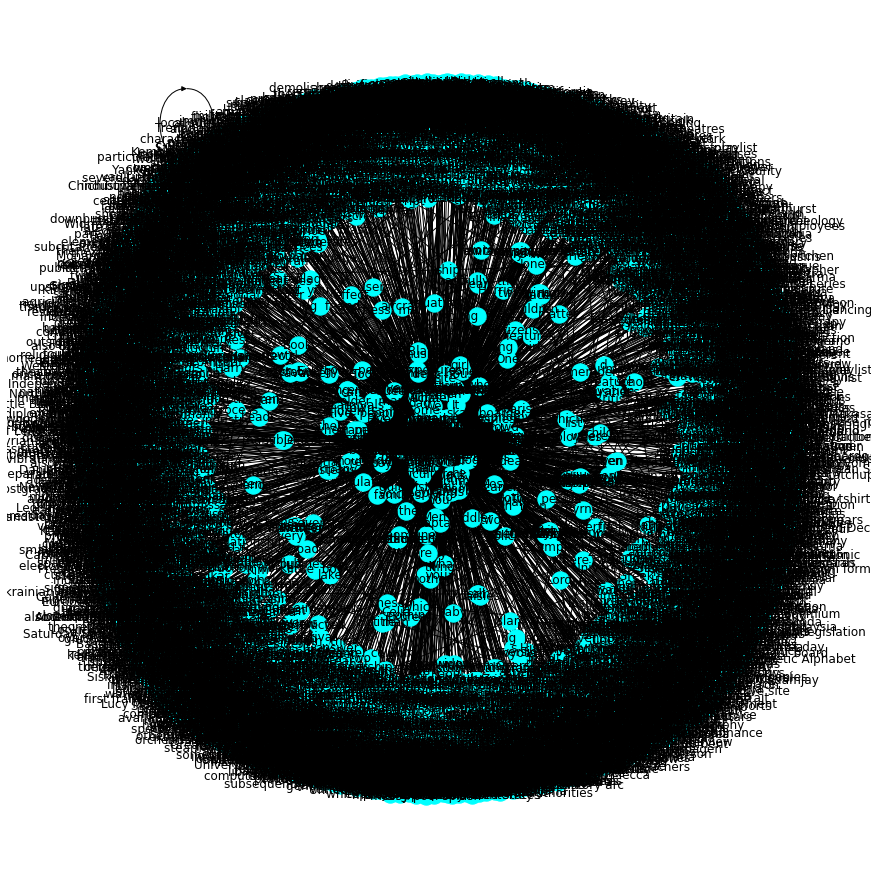

In [ ]:
#Lets plot it using plotly
plt.figure(figsize=(12,12))

pos = nx.spring_layout(graph)
nx.draw(graph, with_labels=True, node_color='Cyan', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

Lets perform some graph analytics and what people are reffering to as 'love' in the dataset

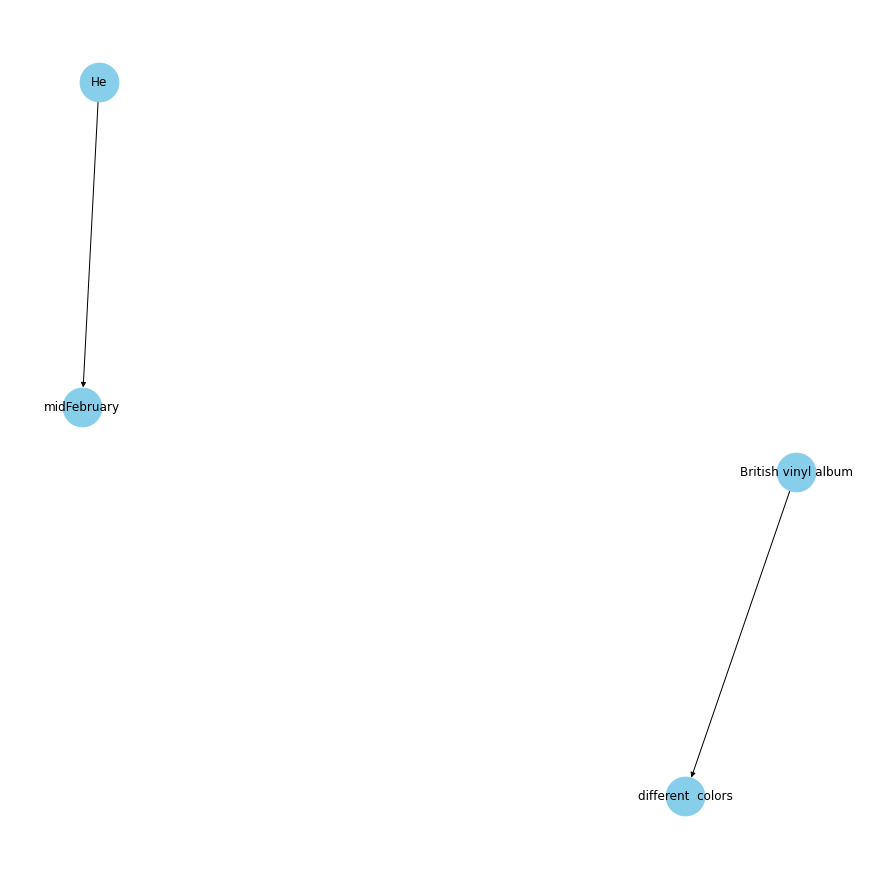

In [ ]:
graph=nx.from_pandas_edgelist(graph_df[graph_df['predicate']=="released in"], "subject", "object", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(graph, k = 0.5) # k regulates the distance between nodes
nx.draw(graph, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

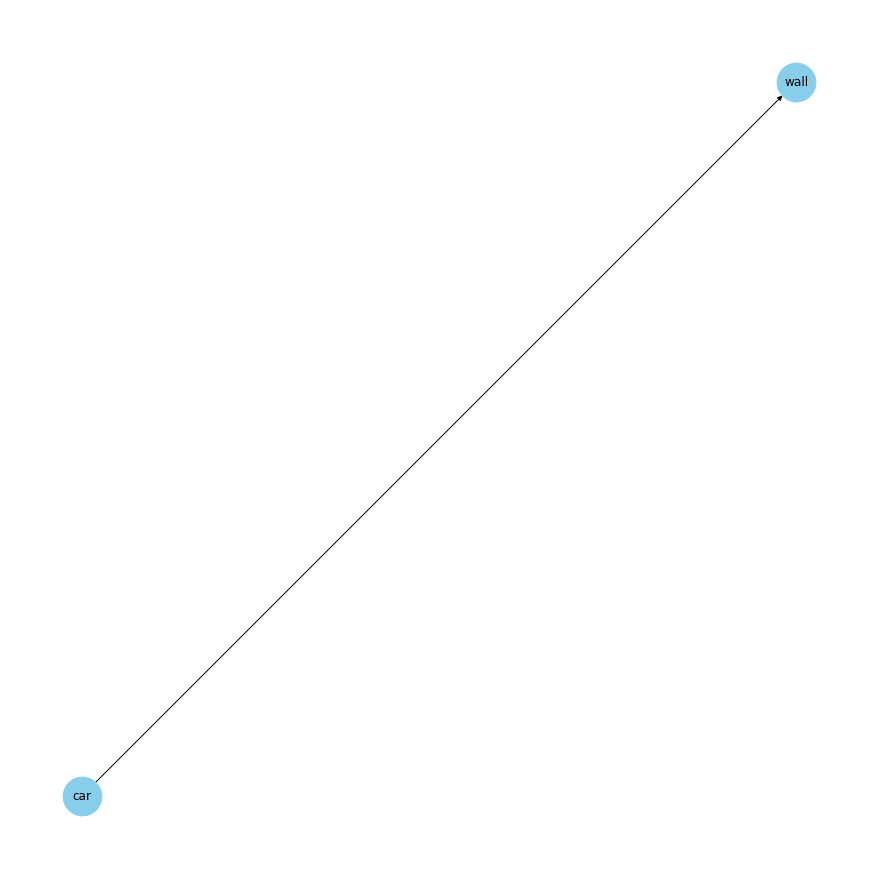

In [ ]:
graph=nx.from_pandas_edgelist(graph_df[graph_df['object']=="wall"], "subject", "object", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(graph, k = 0.5) # k regulates the distance between nodes
nx.draw(graph, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()